In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, smooth, tangential_velocity



#### Drfiter Data

In [2]:
from datetime import datetime
import netCDF4 as nc

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)

drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]
df_drifters.head()


,ID,Lon,Lat,u,v,Time
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00


In [3]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []

rho2s = []
vts = []
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    xi, yi = df_drifters.loc[mask, ['Lon', 'Lat']].values.T
    ui, vi = df_drifters.loc[mask, ['u',   'v'  ]].values.T
    xc_esp, yc_esp, w_esp, Q_esp, Rc_esp, psi0_esp = espra(xi, yi, ui, vi, plot_flag=False) 
    w_esp /= deg_to_m(np.mean(yi))
    q11_esp, q12_esp, q22_esp = Q_esp[0,0], Q_esp[1,0], Q_esp[1,1]

    results.append(dict(xc=xc_esp, yc=yc_esp, w=w_esp,
                        q11=q11_esp, q12=q12_esp, q22=q22_esp,
                        Rc=Rc_esp, psi0=psi0_esp, Time=t))

    dx, dy = xi - xc_esp, yi - yc_esp
    rho2s.extend(q11_esp*dx**2 + 2*q12_esp*dx*dy + q22_esp*dy**2)

    vts.extend(np.abs(tangential_velocity(xi, yi, ui, vi, xc_esp, yc_esp,
                                np.array([[q11_esp, q12_esp],[q12_esp, q22_esp]]))))
        
df_Rc_info = pd.DataFrame({'rho2': rho2s, 'vt': vts})
df_results = pd.DataFrame(results)
df_results


,xc,yc,w,q11,q12,q22,Rc,psi0,Time
0,154.267637,-37.953826,-1.835220e-07,1.130276,-0.102656,0.894063,0.646719,0.002689,2023-10-20 12:00:00
1,154.321904,-37.919899,-2.089448e-07,1.180300,-0.046509,0.849075,0.562943,0.002311,2023-10-21 12:00:00
2,154.235778,-37.942048,-2.148768e-07,0.939455,0.051388,1.067258,0.590595,0.002643,2023-10-22 12:00:00
3,154.169484,-37.965548,-2.316670e-07,0.909202,0.121553,1.116116,0.527249,0.002251,2023-10-23 12:00:00
4,154.153028,-37.911515,-2.248849e-07,0.952993,-0.044465,1.051401,0.547484,0.002382,2023-10-24 12:00:00
...,...,...,...,...,...,...,...,...,...
107,150.676653,-37.187982,-2.496089e-07,1.031158,-0.250171,1.030478,0.457939,0.001804,2024-02-04 12:00:00
108,150.654736,-37.237212,-2.727406e-07,0.852219,-0.275944,1.262756,0.424913,0.001654,2024-02-05 12:00:00
109,150.705005,-37.318210,-2.489821e-07,0.640753,0.184493,1.613785,0.285161,0.000638,2024-02-06 12:00:00
110,150.685157,-37.294499,-3.073088e-07,0.556426,0.259359,1.918075,0.319506,0.000901,2024-02-07 12:00:00


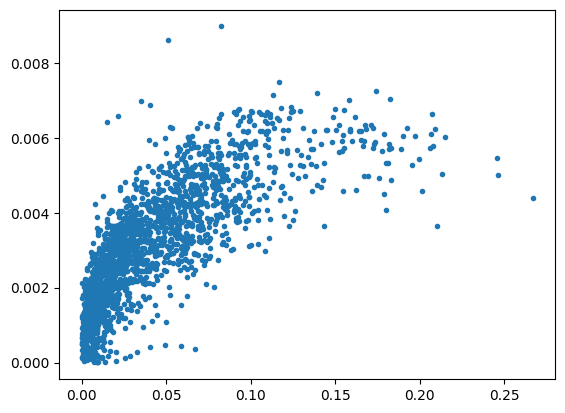

In [4]:
plt.scatter(df_Rc_info.rho2, df_Rc_info.vt, marker='.')



In [8]:
np.sqrt(.1)*np.sqrt(2)

np.float64(0.447213595499958)

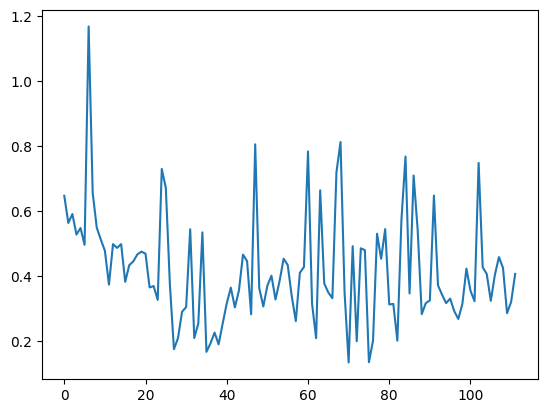

In [5]:
plt.plot(df_results.Rc)
